# Анализ пользовательского поведения в мобильном приложении

**Цель** : oценить влияние изменения шрифтов в мобильном приложении на поведение пользователей и эффективность воронки продаж.

**Задачи:**

1) Изучение воронки продаж для понимания того, как пользователи доходят до покупки. Определение количества пользователей, достигающих этапа покупки, и выявление этапов, на которых пользователи чаще всего "застревают".

2) Анализ результатов A/A/B-эксперимента, проведенного для оценки влияния изменения шрифтов в приложении на поведение пользователей. Сравнение эффективности новых шрифтов с контрольными группами, использующими старые шрифты.


**Исследование будет состоять из следующих этапов:**

Подготовка данных: Открытие и изучение файла с данными, корректировка названий столбцов, проверка и исправление пропусков и типов данных, добавление столбцов с датой и временем.

Анализ данных: Оценка общего количества событий и пользователей в логе, анализ среднего количества событий на пользователя, определение актуального периода данных для исследования.

Исследование воронки событий: Определение последовательности и частоты встречаемости событий, расчет доли пользователей на каждом шаге воронки, выявление этапов с наибольшим оттоком пользователей.

Анализ результатов A/A/B-эксперимента: Проверка корректности разбиения на группы, сравнение показателей между контрольными и экспериментальными группами, оценка эффекта от изменения шрифтов.

Статистический анализ: Определение уровня значимости для статистических тестов, проверка гипотез о различиях между группами.


**В распоряжении имеется лог действий пользователей, где каждая запись включает:**

EventName – название события.

DeviceIDHash – уникальный идентификатор пользователя.

EventTimestamp – время события.

ExpId – номер эксперимента (246 и 247 – контрольные группы, 248 – экспериментальная).


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
import math as mth

pd.set_option('display.max_colwidth', None)# для расширения столбцов

## Загрузка данных

Импортируем файл с данными и изучим общую информацию

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Предобработка данных

Заменим названия столбцов

In [4]:
df = df.rename(
columns={
'EventName': 'event_name',
'DeviceIDHash': 'user_id',
'EventTimestamp': 'eventime',
'ExpId': 'group'}
)

In [5]:
df.head()

,event_name,user_id,eventime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим пропуски

In [6]:
df.isna().sum()

event_name    0
user_id       0
eventime      0
group         0
dtype: int64

Пропуски отсутствуют 

Проверим данные на дубликаты

In [7]:
print(df .duplicated().sum())

413


In [8]:
df.shape

(244126, 4)

Удалим 413 дубликатов, они составляют малую часть от объема данных

In [9]:
df = df.drop_duplicates()
df.shape

(243713, 4)

Проверим попадание одних и тех же пользователей в несколько групп

In [10]:
users_in_multiple_groups = df.groupby('user_id')['group'].nunique()
if users_in_multiple_groups[users_in_multiple_groups > 1].any():
    print('Попадание одних и тех же пользователей в несколько групп присутствует')
else:
    print('Попадание одних и тех же пользователей в несколько групп отсутствует')

Попадание одних и тех же пользователей в несколько групп отсутствует


Проверим типы данных

In [11]:
df.dtypes

event_name    object
user_id        int64
eventime       int64
group          int64
dtype: object

Добавим столбец даты и времени, а также отдельный столбец дат

In [12]:
df['date_time'] = pd.to_datetime(df['eventime'], unit='s')

In [13]:
df['day'] = pd.DatetimeIndex(df['date_time']).date

In [14]:
df.head()

,event_name,user_id,eventime,group,date_time,day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


На данном шаге:

1) Загрузила данные 

2) Заменила названия столбцов в таблице

3) Удалила дубликаты (413 записей)

4) Проверила пропуски (они отсутствуют)

5) Проверила попадание одних и тех же пользователей в несколько групп (Попадание одних и тех же пользователей в несколько групп отсутствует)

6) Проверила тип данных в таблице (добавила столбец даты и времени, а также отдельный столбец дат в типе данных даты)

## Исследовательский анализ данных

### Изучение и проверка данных

Определим сколько всего событий в лог

In [15]:
a = df['event_name'].count()
print(f"Всего {a} событий")

Всего 243713 событий


Определим сколько всего пользователей в логе

In [16]:
b = df['user_id'].nunique()
print(f"Всего {b} уникальных пользователей")

Всего 7551 уникальных пользователей


Определим сколько в среднем событий приходится на пользователя

In [17]:
round(a/b)

32

In [18]:
mean = df.groupby('user_id')['event_name'].count().median()
mean

20.0

В среднем на пользователя 32 события если использовать среднее и 20 если использовать медиану. 

В таких ситуациях медиана представляет собой более надежную меру центральной тенденции, поскольку она менее чувствительна к выбросам. Медиана дает нам представление о "типичном" пользователе, тогда как среднее значение искажается из-за нескольких пользователей с очень высоким количеством событий.

Поэтому в среднем на пользователя приходилось 20 событий

Определим данными за какой период располагаем(найдем максимальную и минимальную дату)

In [19]:
df.agg({'day':['min','max']})

,day
min,2019-07-25
max,2019-08-07


Минимальная дата - 25 июля 2019

Максимальная 7 августа 2019

Изучим, как меняется количество данных. Для этого построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп

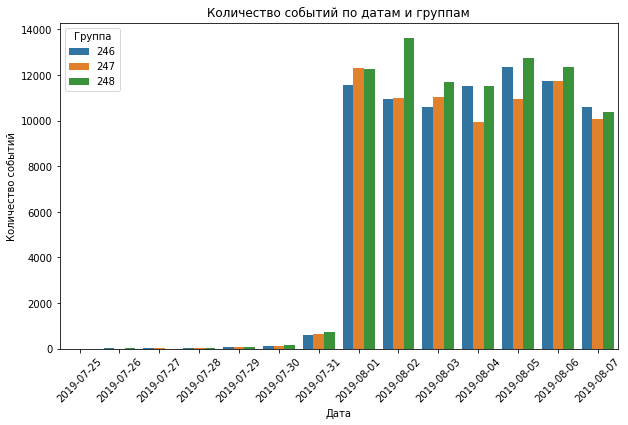

In [20]:
# Группировка и подсчет событий
grouped_data = df.groupby(['day', 'group'])['group'].count().reset_index(name='event_count')


# Построение диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='event_count', hue='group', data=grouped_data)
plt.title('Количество событий по датам и группам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.legend(title='Группа')
plt.show()

Мы не можем быть уверенным, что у вас одинаково полные данные за весь период. 

Из диаграммы мы видим, что данные становятся полными только с 1 августа 2019. Соответственно данные за период с 25 июля 2019 по 31 июля 2019 не полные. 

Стооит использовать данные только с 1 августа 2019

In [21]:
date_string = "2019-08-01"
date_datetime = pd.to_datetime(date_string)

# Используем преобразованный объект datetime в методе query
filtered_data_with_datetime = df.query('day >= @date_datetime')

filtered_data_with_datetime.head()

,event_name,user_id,eventime,group,date_time,day
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Определим много ли событий и пользователей  потеряли, отбросив старые данные

In [22]:
df_drop = df.groupby('user_id',as_index=False )['day'].max().query('day <  @date_datetime')
print(df_drop['user_id'].count())
print('Процент потерь пользователей:', round(df_drop['user_id'].count()/df['user_id'].nunique()*100, 2), '%')

17
Процент потерь пользователей: 0.23 %


In [23]:
df_drop_event = df.query('day < @date_datetime')['event_name'].count()
print(df_drop_event)
print('Процент потерь cобытий:', round(df_drop_event /df['event_name'].count()*100, 2), '%')

2826
Процент потерь cобытий: 1.16 %


После удаления данных мы потеряли 17 пользователей и 2 826 событий

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [24]:
filtered_data_with_datetime.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Мы провели тщательный анализ и верификацию данных. Было установлено, что в нашей таблице содержится 243713 событий, связанных с 7551 уникальным пользователем. 

В среднем на каждого пользователя приходится около 20 событий. 

Мы удалили данные до 1 августа для устранения возможного искажения результатов. В результате этого процесса были исключены 17 пользователей и 2826 событий. Однако это исключение вряд ли окажет значительное влияние на общие выводы нашего исследования. Наша таблица включает в себя представителей всех групп пользователей в достаточном и сбалансированном количестве.

### Изучение воронки событий

Определим какие события есть в логах, как часто они встречаются, и отсортируем события по частоте

In [25]:
# Подсчитаем частоту встречаемости каждого события
event_counts = filtered_data_with_datetime["event_name"].value_counts().reset_index()
event_counts.columns = ["event_name", "frequency"]

# Отсортируем события по частоте встречаемости
sorted_events = event_counts.sort_values(by="frequency", ascending=False)

# Выведем результаты
print("События и их частота встречаемости:")
print(sorted_events)

События и их частота встречаемости:
                event_name  frequency
0         MainScreenAppear     117328
1       OffersScreenAppear      46333
2         CartScreenAppear      42303
3  PaymentScreenSuccessful      33918
4                 Tutorial       1005


Всего 5 событий:
    
Главный экран

Экран предложений

Экран корзины 

Экран оплаты 

Руководство

Посчитаем сколько пользователей совершали каждое из этих событий, и отсортируйте события по числу пользователей

In [26]:
event_users = filtered_data_with_datetime.groupby('event_name')['user_id'].nunique().reset_index()
event_users.columns = ["event_name", "frequency_users"]

# Отсортируем события по частоте встречаемости
sorted_events_users = event_users.sort_values(by="frequency_users", ascending=False)

# Выведем результаты
print("События и и количество пользователей:")
print(sorted_events_users)

События и и количество пользователей:
                event_name  frequency_users
1         MainScreenAppear             7419
2       OffersScreenAppear             4593
0         CartScreenAppear             3734
3  PaymentScreenSuccessful             3539
4                 Tutorial              840


Больше всего пользователей заходят на главный экран,  а меньше всего проходят обучение 

Посчитаем долю пользователей, которые хоть раз совершали событие

In [27]:
#Объединим количество событий и количество человек
df_1 = sorted_events.merge(sorted_events_users, on = 'event_name')

In [28]:
#Посчитаем общее количество уникальных человек
total_users = filtered_data_with_datetime['user_id'].nunique()
print('Общее количество уникальных пользователей, совершивших события:', total_users)

Общее количество уникальных пользователей, совершивших события: 7534


In [29]:
#Посчитаем долю пользователей которые выполнили событие
df_1['percent'] = round(df_1['frequency_users'] / total_users * 100 ,2)
df_1

,event_name,frequency,frequency_users,percent
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


около 1,5% пользователей миновали главный экран, так как возможно у них уже была ссылка на товар 

Всего уникальных пользователей получилось 7 534.

На главный экран попадало 98 процентов пользователей, что является нормальным значением

47 % пользователей прошли до оплаты 

Обучение оказалось интересным только 11 процентам пользователям

Вероятно, путь пользователя в приложении начинается с основного экрана (MainScreenAppear), после чего он переходит к просмотру предложений (OffersScreenAppear). Если пользователь находит интересный товар, он добавляет его в корзину (CartScreenAppear), а затем производит оплату (PaymentScreenSuccessful), если товар его полностью удовлетворяет. Существует также обучающий элемент (Tutorial), но, по всей видимости, пользователи часто его пропускают, возможно из-за простоты и интуитивной понятности приложения, так что его можно не включать в анализ воронки.

Определим в каком порядке происходят события(есть ли последовательная цепочка)

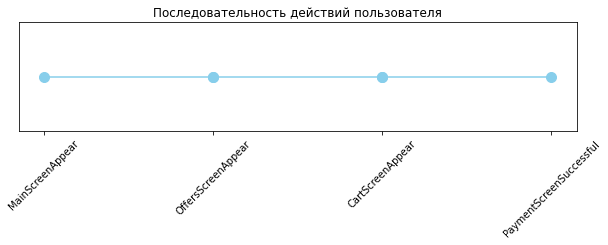

In [30]:
# Задаем последовательность действий пользователя
actions = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"]

# Создаем список индексов для действий
indices = list(range(len(actions)))

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(10, 2))
plt.xticks(indices, actions, fontsize=10, rotation=45)

# Рисуем горизонтальные линии для представления последовательности
for i in range(len(actions) - 1):
    ax.plot([indices[i], indices[i + 1]], [0, 0], marker='o', linestyle='-', markersize=10, color='skyblue')

# Устанавливаем заголовок
plt.title("Последовательность действий пользователя")

# Убираем оси
ax.get_yaxis().set_visible(False)

# Отображаем диаграмму
plt.show()


Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)( То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B)

In [31]:
df_2 = df_1[:4]
df_2

,event_name,frequency,frequency_users,percent
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97


In [32]:
# Создание копии подмножества для безопасного изменения
df_2 = df_2.copy()

# Теперь можно безопасно изменять df_2
df_2['conversion'] = round(df_2['frequency_users'] / df_2['frequency_users'].shift(1),2)
df_2 = df_2.fillna(1)
df_2

,event_name,frequency,frequency_users,percent,conversion
0,MainScreenAppear,117328,7419,98.47,1.00
1,OffersScreenAppear,46333,4593,60.96,0.62
2,CartScreenAppear,42303,3734,49.56,0.81
3,PaymentScreenSuccessful,33918,3539,46.97,0.95


Большая часть пользователей (98.47%) начинает свой путь с главного экрана, но только 62% из них переходят к экрану предложений. Это указывает на потенциальную проблему на начальном этапе взаимодействия пользователя с приложением.

Затем 81% пользователей, просмотревших предложения, переходят в корзину, что является достаточно высоким показателем.
Почти все пользователи (95%), которые добавили товары в корзину, производят оплату, что свидетельствует об эффективности последнего этапа воронки.

Общий вывод: Следует уделить внимание первому шагу воронки (переходу с главного экрана к экрану предложений) для увеличения общей конверсии. Этапы корзины и оплаты работают эффективно.

Посчитаем какая доля пользователей доходит от первого события до оплаты

Доля пользователей, которая доходит от первого события до оплаты, можно рассчитать как произведение конверсий между каждым последующим шагом воронки. В данном случае:

In [33]:
total_conversion = df_2['conversion'].prod()

# Выводим результат
print(f"Доля пользователей, дошедших от главного экрана до оплаты: {round(total_conversion*100,2)}%")


Доля пользователей, дошедших от главного экрана до оплаты: 47.71%


**Вывод**

1) Всего в приложении 5 событий: переход на главный экран, переход на экран предложения товара; добавление товара в корзину; его оплата(так же некоторые пользователи не пропускают на начальном этапе шаг обучения, но их доля слишком мала)

2) Больше всего пользователей заходят на главный экран,  а меньше всего проходят обучение 

3) Всего уникальных пользователей получилось 7 534. На главный экран попадало 98 процентов пользователей, что является нормальным значением. 47 % пользователей прошли до оплаты 

4) Большая часть пользователей (98.47%) начинает свой путь с главного экрана, но только 62% из них переходят к экрану предложений. Это указывает на потенциальную проблему на начальном этапе взаимодействия пользователя с приложением.

Затем 81% пользователей, просмотревших предложения, переходят в корзину, что является достаточно высоким показателем.
Почти все пользователи (95%), которые добавили товары в корзину, производят оплату, что свидетельствует об эффективности последнего этапа воронки.

5) Доля пользователей, дошедших от главного экрана до оплаты: 47.71%

Общий вывод: Следует уделить внимание первому шагу воронки (переходу с главного экрана к экрану предложений) для увеличения общей конверсии. Этапы корзины и оплаты работают эффективно.

### Изучение результата эксперимента

Определим сколько пользователей в каждой экспериментальной группе

In [34]:
total_group_users = filtered_data_with_datetime.groupby('group')['user_id'].nunique().reset_index()
total_group_users.columns = ["group", "total_users"]

total_group_users

,group,total_users
0,246,2484
1,247,2513
2,248,2537


Выберем самое популярное событие и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп.

In [35]:
group_246 = filtered_data_with_datetime.query('group == 246').groupby('event_name')['user_id'].nunique().\
reset_index().sort_values(by = 'user_id',ascending = False)

In [36]:
group_247 = filtered_data_with_datetime.query('group == 247').groupby('event_name')['user_id'].nunique().\
reset_index().sort_values(by = 'user_id',ascending = False)

In [37]:
group_248 = filtered_data_with_datetime.query('group == 248').groupby('event_name')['user_id'].nunique().\
reset_index().sort_values(by = 'user_id',ascending = False)

In [38]:
merged_246_247 = group_246.merge(
    group_247,
    on='event_name', # название столбца, по которому объединять, передают в параметре on
)

merged_246_247.rename(
    columns={
        'user_id_x': 'number_users_246',
        'user_id_y': 'number_users_247'
    },
    inplace=True
)
merged_246_247_258= merged_246_247.merge(
    group_248,
    on='event_name', # название столбца, по которому объединять, передают в параметре on
)
merged_246_247_258.rename(
    columns={
        'user_id': 'number_users_248',
       },
    inplace=True
)
merged_246_247_258

,event_name,number_users_246,number_users_247,number_users_248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [39]:
merged_246_247_258['number_users_246_247'] = merged_246_247_258['number_users_246'] + merged_246_247_258['number_users_247']
merged_246_247_258.head(2)

,event_name,number_users_246,number_users_247,number_users_248,number_users_246_247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062


Самое популярное событие это MainScreenAppear и в группе 246 и в 247

Посчитаем долю пользователей, совершивших это событие.

In [40]:
print("Доля пользователей, совершивших популярное событие в группе 246:",\
      round(merged_246_247_258.loc[0, 'number_users_246'] / 
      total_group_users['total_users'].iloc[0],3))


Доля пользователей, совершивших популярное событие в группе 246: 0.986


In [41]:
print("Доля пользователей, совершивших популярное событие в группе 247:",\
      round(merged_246_247_258.loc[0, 'number_users_247'] / 
      total_group_users['total_users'].iloc[1],3))

Доля пользователей, совершивших популярное событие в группе 247: 0.985


Проверим, будет ли отличие между контрольными группами статистически достоверным

**Сформулируем гипотезы**

Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

Пороговое значение alpha примем за 5%.

**Проверять гипотезу о равенстве долей будем при помощи Z-критерия**

In [42]:
def x (a,b):
    for event in a['event_name'].unique():
        alpha = .05 # критический уровень статистической значимости
# Получаем количество успехов для каждой группы для конкретного события
        event_data = a[a['event_name'] == event]
        successes = np.array([event_data['number_users_246'].values[0], event_data['number_users_247'].values[0]])
        trials = np.array([b[b['group'] == 246]['total_users'].values[0], b[b['group'] == 247]['total_users'].values[0]])
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(event, 'p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями контрольных групп есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными') 

users = x(merged_246_247_258,total_group_users)

MainScreenAppear p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными
OffersScreenAppear p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными
CartScreenAppear p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными
PaymentScreenSuccessful p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными
Tutorial p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли контрольных групп разными


Между группами контрольными группами отсутствует отличие 

Если A/A-тест показывает, что различий между группами нет, это значит, что система тестирования работает правильно. Это важно, чтобы быть уверены, что любые различия, найденные в последующем A/B-тесте (где тестируется нововведение), действительно вызваны этим нововведением, а не случайностью или ошибкой в системе.

Сравним результаты с каждой из контрольных групп в отдельности с экспериментальной группой по каждому событию

**Сформулируем гипотезы**

Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

Пороговое значение alpha примем за 5%.

**Проверять гипотезу о равенстве долей будем при помощи Z-критерия**

In [43]:
def y (a,b):
    for event in a['event_name'].unique():
        alpha = .05 # критический уровень статистической значимости
# Получаем количество успехов для каждой группы для конкретного события
        event_data = a[a['event_name'] == event]
        successes = np.array([event_data['number_users_246'].values[0], event_data['number_users_248'].values[0]])
        trials = np.array([b[b['group'] == 246]['total_users'].values[0], b[b['group'] == 248]['total_users'].values[0]])
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(event, 'p-значение: ', round(p_value,2))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями групп 246 и 248 есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными') 

users = y(merged_246_247_258,total_group_users)

MainScreenAppear p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными
OffersScreenAppear p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными
CartScreenAppear p-значение:  0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными
PaymentScreenSuccessful p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными
Tutorial p-значение:  0.83
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными


Различия между группами 246 и 248 статистически не значимы

**Сформулируем гипотезы**

Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

Пороговое значение alpha примем за 5%.

**Проверять гипотезу о равенстве долей будем при помощи Z-критерия**

In [44]:
def z (a,b):
    for event in a['event_name'].unique():
        alpha = .05 # критический уровень статистической значимости
# Получаем количество успехов для каждой группы для конкретного события
        event_data = a[a['event_name'] == event]
        successes = np.array([event_data['number_users_247'].values[0], event_data['number_users_248'].values[0]])
        trials = np.array([b[b['group'] == 247]['total_users'].values[0], b[b['group'] == 248]['total_users'].values[0]])
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(event, 'p-значение: ', round(p_value,2))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями групп 247 и 248 есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными') 

users = z(merged_246_247_258,total_group_users)

MainScreenAppear p-значение:  0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
OffersScreenAppear p-значение:  0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
CartScreenAppear p-значение:  0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
PaymentScreenSuccessful p-значение:  0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
Tutorial p-значение:  0.77
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными


Различия между группами 247 и 248 статистически не значимы

Сравним результаты  тестовой группы с объединённой контрольной группой

**Сформулируем гипотезы**

Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

Пороговое значение alpha примем за 5%.

**Проверять гипотезу о равенстве долей будем при помощи Z-критерия**

In [45]:
# Отфильтровываем строки для групп 246 и 247
total_users_246 = total_group_users[total_group_users['group'] == 246]['total_users'].values[0]
total_users_247 = total_group_users[total_group_users['group'] == 247]['total_users'].values[0]

# Складываем значения для групп 246 и 247
total_users_246_247 = total_users_246 + total_users_247

In [46]:
def z (a,b,c):
    for event in a['event_name'].unique():
        alpha = .05 # критический уровень статистической значимости
# Получаем количество успехов для каждой группы для конкретного события
        event_data = a[a['event_name'] == event]
        successes = np.array([event_data['number_users_246_247'].values[0], event_data['number_users_248'].values[0]])
        trials = np.array([c, b[b['group'] == 248]['total_users'].values[0]])
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(event, 'p-значение: ', round(p_value,2))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями групп 247 и 248 есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными') 

users = z(merged_246_247_258,total_group_users,total_users_246_247)

MainScreenAppear p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
OffersScreenAppear p-значение:  0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
CartScreenAppear p-значение:  0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
PaymentScreenSuccessful p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными
Tutorial p-значение:  0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными


Различия тестовой группы с объединённой контрольной группой статистически не значимы

Уровень статистической значимости выбран 0,05. 

Он является оптимальным, так как по формуле 1-(1-a)^k получается, что при уровне значимости 5%, вероятность ошибиться хотя бы один раз за два сравнения составляет 9.75% (так как 1-(1-0.05)^2 ≈ 0.0975 или 9.75%). 

Если выбрать уровень значимости 10%, вероятность ошибиться хотя бы один раз за два сравнения увеличивается до примерно 19% (1-(1-0.1)^2 ≈ 0.19). Это слишком высоко, так как вероятность отклонить нулевую гипотезу (H0), когда она верна, возрастает — это ошибка первого рода. 

В то же время, если установить уровень значимости в 1%, вероятность ошибиться хотя бы один раз за два сравнения снижается до примерно 2% (1-(1-0.01)^2 ≈ 0.0199). Однако такой жесткий критерий увеличивает риск совершения ошибки второго рода, то есть принятия нулевой гипотезы (H0), хотя она неверна

Было выполнено 20 проверок статистических гипотез

В результате выполненных анализов стало ясно, что между исследуемыми группами не наблюдается статистически значимых отличий во всех проведенных тестах. Это означает, что изменение шрифта не оказало заметного влияния на поведение пользователей.

### Общий вывод

На этапах: 

**1) Изучение и проверка данных:**

Мы провели тщательный анализ и верификацию данных. Было установлено, что в нашей таблице содержится 243713 событий, связанных с 7551 уникальным пользователем. 

В среднем на каждого пользователя приходится около 20 событий. 

Мы удалили данные до 1 августа для устранения возможного искажения результатов. В результате этого процесса были исключены 17 пользователей и 2826 событий. Однако это исключение вряд ли окажет значительное влияние на общие выводы нашего исследования. Наша таблица включает в себя представителей всех групп пользователей в достаточном и сбалансированном количестве.

**2) Изучение воронки событий:**

1) Всего в приложении 5 событий: переход на главный экран, переход на экран предложения товара; добавление товара в корзину; его оплата(так же некоторые пользователи не пропускают на начальном этапе шаг обучения, но их доля слишком мала)

2) Больше всего пользователей заходят на главный экран,  а меньше всего проходят обучение 

3) Всего уникальных пользователей получилось 7 534. На главный экран попадало 98 процентов пользователей, что является нормальным значением. 47 % пользователей прошли до оплаты 

4) Большая часть пользователей (98.47%) начинает свой путь с главного экрана, но только 62% из них переходят к экрану предложений. Это указывает на потенциальную проблему на начальном этапе взаимодействия пользователя с приложением.

Затем 81% пользователей, просмотревших предложения, переходят в корзину, что является достаточно высоким показателем.
Почти все пользователи (95%), которые добавили товары в корзину, производят оплату, что свидетельствует об эффективности последнего этапа воронки.

5) Доля пользователей, дошедших от главного экрана до оплаты: 47.71%

Общий вывод: Следует уделить внимание первому шагу воронки (переходу с главного экрана к экрану предложений) для увеличения общей конверсии. Этапы корзины и оплаты работают эффективно.


**3) Изучение результатов эксперимента:**

Было выполнено 20 проверок статистических гипотез

Уровень статистической значимости выбран 0,05

В результате выполненных анализов стало ясно, что между исследуемыми группами не наблюдается статистически значимых отличий во всех проведенных тестах. Это означает, что изменение шрифта не оказало заметного влияния на поведение пользователей.